In [1]:
  #Mount Google drive 
  from google.colab import drive 
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from zipfile import ZipFile
file_name = "/content/drive/My Drive/Colab Notebooks/dataset_cat_dog.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("unzipping completed")

unzipping completed


In [5]:
!pip install -q keras 

In [6]:
#Get Necessary libraries 
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization


#Initializing CNN 
CNN_Classifier =Sequential();

#STEP:1 Covolution 
CNN_Classifier.add(Conv2D(32,(3,3), input_shape=(64,64,3),activation='relu'))
CNN_Classifier.add(BatchNormalization())
#32 no of fiilter  3,3 is the filter size 
#input_shape=height, width and dimension 3=RGB of each image 
#STEP :2 Pooling 
CNN_Classifier.add(MaxPooling2D(2,2))

# Add one more Convolution +pooling  layer 
#reduce no of filter 
CNN_Classifier.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
CNN_Classifier.add(BatchNormalization())
CNN_Classifier.add(MaxPooling2D((2, 2), name='maxpool_2'))
CNN_Classifier.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
CNN_Classifier.add(BatchNormalization())
CNN_Classifier.add(MaxPooling2D((2, 2), name='maxpool_3'))

#STEP 3 :Flattening
CNN_Classifier.add(Flatten())


#STEP 4 :Full Connection 
#Hiddden layer with 128 neuron 
CNN_Classifier.add(Dense(units=256, activation='relu'))
CNN_Classifier.add(Dropout(0.3))
CNN_Classifier.add(Dense(units=256, activation='relu'))
CNN_Classifier.add(Dropout(0.3))
#output layer with sigmoid 
CNN_Classifier.add(Dense(units=1, activation='sigmoid'))

#STEP 5 : Compiling 
CNN_Classifier.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])







In [9]:
CNN_Classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 31, 31, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 15, 15, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 15, 15, 128)       7

In [10]:
#DATA AUGMENTATION TO AVOID OVERFITTING 
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
            rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
#Meaning of each parameter :
#rescale=1./255:meaning Every pixel will have value between 0 to 255 .Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1]
#        benefit :both higher and lower pixel image will be treated equally 
#rotation_range=40:image will be rotated 40 degree
#zoom_range=0.2: Image will be zoomed 20 percent 


training_set = train_datagen.flow_from_directory(
        '/content/dataset/training_set',
        target_size=(64, 64),#same as input_shape
        batch_size=32,
        class_mode='binary')

test_set = test_datagen.flow_from_directory(
        '/content/dataset/test_set',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

#Takes the path to a directory & generates batches of augmented data.
# use flow from directory  only when we have  separate training and test folder and 
#inside training and testing folder each folder represents a class 
#meaning of each parameter ::
#directory: string, path to the target directory. """It should contain one subdirectory per class"""
#target_size: Tuple of integers (height, width), defaults to (256, 256). The dimensions to which all images found will be resized.
#color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb".
#class_mode: One of "categorical", "binary", "sparse", "input", or None. Default: "categorical".
  # Determines the type of label arrays that are returned: 
  #- "categorical" will be 2D one-hot encoded labels, 
  #- "binary" will be 1D binary labels, "sparse" will be 1D integer labels, 
  #- "input" will be images identical to input images (mainly used to work with autoencoders). 
  #- If None, no labels are returned 
#batch_size: Size of the batches of data (default: 32).

# history =CNN_Classifier.fit(
#         training_set,
#         steps_per_epoch=200,
#         epochs=20,
#         validation_data=test_set,
#         validation_steps=100, verbose=1)
history =CNN_Classifier.fit_generator(
        training_set,
        steps_per_epoch=training_set.samples / training_set.batch_size - 1,#training total image =batch_size * steps_per_epoch
        epochs=30,
        validation_data=test_set,
        validation_steps=test_set.samples / test_set.batch_size - 1, #testing total image =batch_size * validation_steps
        verbose=1)

#model.fit and model.fit_generator 
#.fit is used when the entire training dataset can fit into the memory and no data augmentation is applied.
#.fit_generator is used when either we have a huge dataset to fit into our memory or when data augmentation needs to be applied.
#parameter of fit_generator :
#training data :training_set (here)
# steps_per_epoch : it specifies the total number of steps taken from the generator as soon as one epoch is finished and next epoch has started. 
#We can calculate the value of steps_per_epoch as the total number of samples in your dataset divided by the batch size.here 8000/32= 250
#-> Epochs : an integer and number of epochs we want to train our model for.
#-> Verbose : specifies verbosity mode(0 = silent, 1= progress bar, 2 = one line per epoch).
#-> validation_data is the test data : test_set here 
#-> validation_steps :only if the validation_data is a generator then only this argumentcan be used. It specifies the total number of steps taken from 
#the generator before it is stopped at every epoch and
# its value is calculated as the total number of training data points in your dataset divided by the batch size. here 2000/32= 60


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30
249/249 [==============================] - 39s 155ms/step - loss: 0.6785 - accuracy: 0.5948 - val_loss: 0.6388 - val_accuracy: 0.6497
Epoch 2/30
249/249 [==============================] - 38s 154ms/step - loss: 0.6560 - accuracy: 0.6076 - val_loss: 0.6053 - val_accuracy: 0.6719
Epoch 3/30
249/249 [==============================] - 39s 157ms/step - loss: 0.6353 - accuracy: 0.6382 - val_loss: 0.6353 - val_accuracy: 0.6386
Epoch 4/30
249/249 [==============================] - 39s 158ms/step - loss: 0.6145 - accuracy: 0.6670 - val_loss: 0.5869 - val_accuracy: 0.6769
Epoch 5/30
249/249 [==============================] - 39s 155ms/step - loss: 0.5939 - accuracy: 0.6816 - val_loss: 0.5467 - val_accuracy: 0.7273
Epoch 6/30
249/249 [==============================] - 38s 154ms/step - loss: 0.5770 - accuracy: 0.6959 - val_loss: 0.5264 - val_accuracy: 0.7540
Epoch 7/30
249/249 [==========================

In [11]:
#USE SINGLE IMAGE FOR PREDICTION 
import numpy as np
from keras.preprocessing import image
test_image= image.load_img('/content/dataset/single_prediction/cat_or_dog_1.jpg',target_size=(64,64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = CNN_Classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  print("prediction is dog ")
else:
  print("prediction is cat ")


prediction is dog 


In [12]:
!pip install h5py

#h5 file stores model and architecture together

#Saving model 
CNN_Classifier.save("/content/drive/My Drive/Colab Notebooks/CNN_classifier_cat_dog.h5")

In [13]:
#predicting output from model 
from tensorflow.python.keras.models import load_model 
# load model
loaded_model = load_model("/content/drive/My Drive/Colab Notebooks/CNN_classifier_cat_dog.h5")
import numpy as np
from keras.preprocessing import image
test_image= image.load_img('/content/dataset/single_prediction/cat_or_dog_1.jpg',target_size=(64,64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = loaded_model.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  print("prediction is dog ")
else:
  print("prediction is cat ")

prediction is dog 


In [14]:
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history
def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    acc = smooth_curve(history.history['accuracy'][:steps])
    val_acc = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

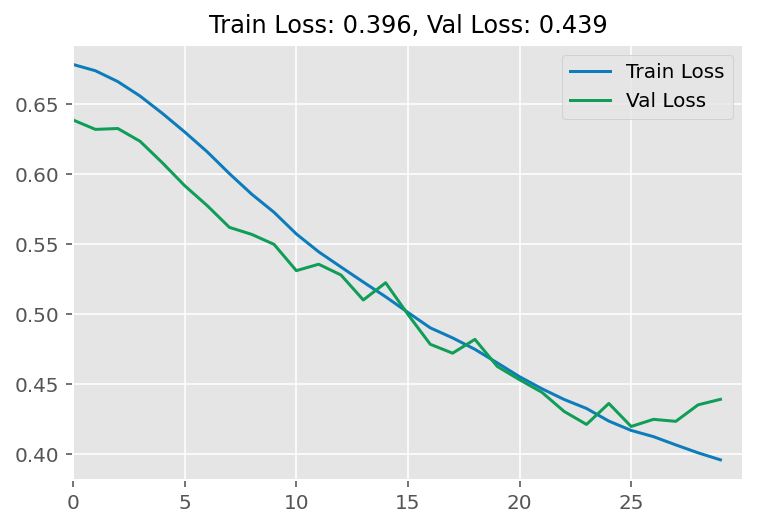

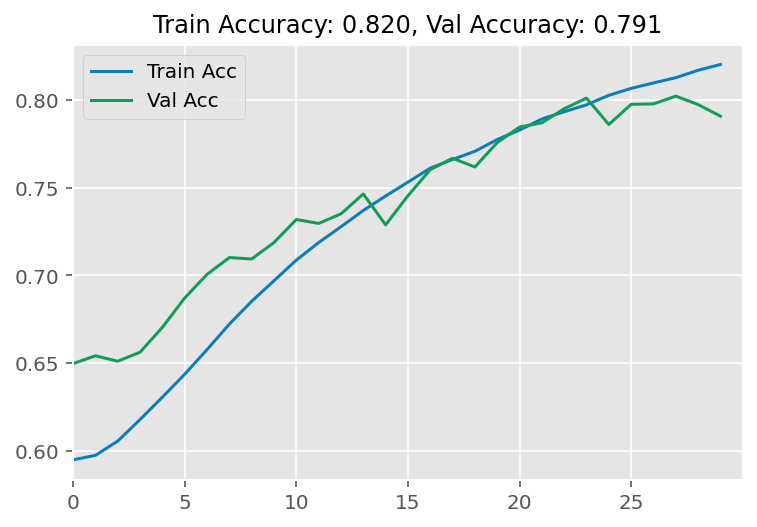

In [15]:
import pickle
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
save_history(history, '/content/drive/My Drive/Colab Notebooks/history.bin')
history = load_history('/content/drive/My Drive/Colab Notebooks/history.bin')
plot_compare(history)